In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import random

In [2]:
sys.path.append("/home/j622s/Desktop/SilverFox/")
from datasets.dataset_crosses import RandomCrossDataset, draw_x, RandomXDataset
from datasets.dataset_alien import SimplyNumpyDataset4, SimplyNumpyDataset5, SimplyNumpyDataset6_SilverFox

In [3]:
# load the model
import nibabel as nib
from torchvision.transforms import Compose, Lambda

import sys
import json


from diffusion_model.trainer_brats import GaussianDiffusion, Trainer
from diffusion_model.unet_brats import create_model
from datasets.dataset_crosses import RandomCrossDataset
import torch
import os

APEX: ON


In [4]:
path_to_loading_folder = "/DATA/j622s/SilverFoxResults/3:2:256"
path_to_config_file = os.path.join(path_to_loading_folder, "config.txt")
assert os.path.exists(path_to_config_file), "The config file does not exist"

with open(os.path.join(path_to_config_file), "r") as f:
    dictionary = json.load(f)

In [5]:
# load the parameters
input_size = dictionary["input_size"]
depth_size = dictionary["depth_size"]
num_channels = dictionary["num_channels"]
num_res_blocks = dictionary["num_res_blocks"]
channel_mult = dictionary["channel_mult"]
learn_sigma = dictionary["learn_sigma"]
in_channels = dictionary["in_channels"]
out_channels = dictionary["out_channels"]
class_cond = dictionary["class_cond"]
use_checkpoint = dictionary["use_checkpoint"]
attention_resolutions = dictionary["attention_resolutions"]
num_heads = dictionary["num_heads"]
num_head_channels = dictionary["num_head_channels"]
num_heads_upsample = dictionary["num_heads_upsample"]
use_scale_shift_norm = dictionary["use_scale_shift_norm"]
dropout = dictionary["dropout"]
resblock_updown = dictionary["resblock_updown"]
use_fp16 = dictionary["use_fp16"]
dims = dictionary["dims"]
conv_resample = dictionary["conv_resample"]
use_new_attention_order = dictionary["use_new_attention_order"]
batchsize = dictionary["batchsize"]
train_lr = dictionary["train_lr"]
epochs = dictionary["epochs"]
gradient_accumulate_every = dictionary["gradient_accumulate_every"]
ema_decay = dictionary["ema_decay"]
step_start_ema = dictionary["step_start_ema"]
update_ema_every = dictionary["update_ema_every"]
save_and_sample_every = dictionary["save_and_sample_every"]
# results_folder = dictionary["results_folder"]
results_folder = path_to_loading_folder
timesteps = dictionary["timesteps"]

In [6]:
# with_cond = False 

In [7]:
print(class_cond)

True


In [8]:
data_folder = "/DATA/j622s/new_dataset_7/numpy_dataset_2D_128_classes"
dataset = SimplyNumpyDataset6_SilverFox(
    path_to_dataset=data_folder,
    output_size=input_size,
)


In [15]:
index = 3
image = dataset[index][0]
class_label = dataset[index][1] 

print(image.shape, class_label, image[0:4, 0:4])

(1, 256, 256) 30 [[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]]


In [16]:
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'Class label: 30')

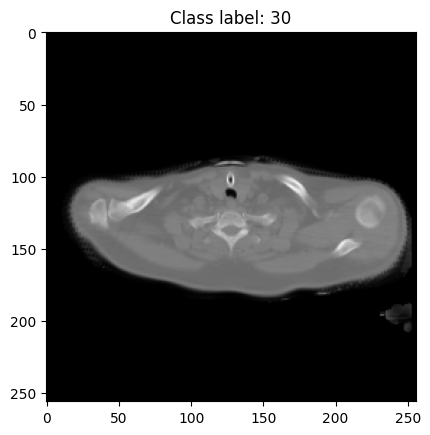

In [17]:
plt.imshow(image[0], cmap="gray")
plt.title(f"Class label: {class_label}")

In [8]:
# # configuration of data
# input_size = 256  # the size of image
# depth_size = 0  # the size of classes

# # configuration of training
# batchsize = 4
# epochs = 1e7
# save_and_sample_every = 2500
# resume_weight = ""
# train_lr = 1e-4
# step_start_ema = 1e4
# gradient_accumulate_every = 4
# update_ema_every = 10
# ema_decay = 0.995

# # configuration of network
# num_channels = 96 * 2
# num_res_blocks = 2
# num_heads = 3
# num_head_channels = -1
# num_heads_upsample = -1
# dropout = 0.05
# conv_resample = True
# dims = 2
# num_classes = 128
# resblock_updown = True
# use_new_attention_order = True

# in_channels = 1
# out_channels = 1

# channel_mult = ""
# learn_sigma = False
# class_cond = True
# with_cond = False
# use_checkpoint = False
# attention_resolutions = "16,8"
# use_scale_shift_norm = False
# use_fp16 = True
# timesteps = 500
# result_name = f"results_2D_{input_size}_nc:{num_channels}_att:{attention_resolutions}_lr:{train_lr}_timestep:{timesteps}_nh:{num_heads}_nrb:{num_res_blocks}"


In [9]:
model = create_model(
    image_size=input_size,
    num_channels=num_channels,
    num_res_blocks=num_res_blocks,
    channel_mult=channel_mult,
    learn_sigma=learn_sigma,
    in_channels=in_channels,
    out_channels=out_channels,
    class_cond=class_cond,
    conv_resample=conv_resample,
    dims=dims,
    use_checkpoint=use_checkpoint,
    attention_resolutions=attention_resolutions,
    num_heads=num_heads,
    num_head_channels=num_head_channels,
    num_heads_upsample=num_heads_upsample,
    use_scale_shift_norm=use_scale_shift_norm,
    dropout=dropout,
    resblock_updown=resblock_updown,
    use_fp16=use_fp16,
    use_new_attention_order=use_new_attention_order,
).cuda()

diffusion = GaussianDiffusion(
    denoise_fn=model,
    image_size=input_size,
    depth_size=depth_size,
    channels=in_channels,
    timesteps=timesteps,
    loss_type="l1",
    betas=None,
    with_pairwised=False,
    apply_bce=False,
    lambda_bce=0.0,
).cuda()

trainer = Trainer(
    diffusion_model=diffusion,
    dataset=dataset,
    ema_decay=ema_decay,
    depth_size=depth_size,
    train_batch_size=batchsize,
    train_lr=train_lr,
    train_num_steps=epochs,
    gradient_accumulate_every=gradient_accumulate_every,
    fp16=use_fp16,
    step_start_ema=step_start_ema,
    update_ema_every=update_ema_every,
    save_and_sample_every=save_and_sample_every,
    results_folder=results_folder,
    with_class_guided=class_cond,
    with_condition=False
)

trainer.load(milestone=80)

/home/j622s/Desktop/SilverFox/.venv/lib/python3.8/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.amp is deprecated and will be removed by the end of February 2023. Use [PyTorch AMP](https://pytorch.org/docs/stable/amp.html)
  warnings.warn(msg, DeprecatedFeatureWarning)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [14]:
bs = 5
total_samples = 10
elements = trainer.generate_and_return_samples(no_of_samples=total_samples, batch_size=bs, y=torch.tensor([64 for x in range(total_samples)]))

elements = elements.cpu().detach().numpy()
elements = np.squeeze(elements)

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step: 100%|██████████| 500/500 [00:58<00:00,  8.55it/s]


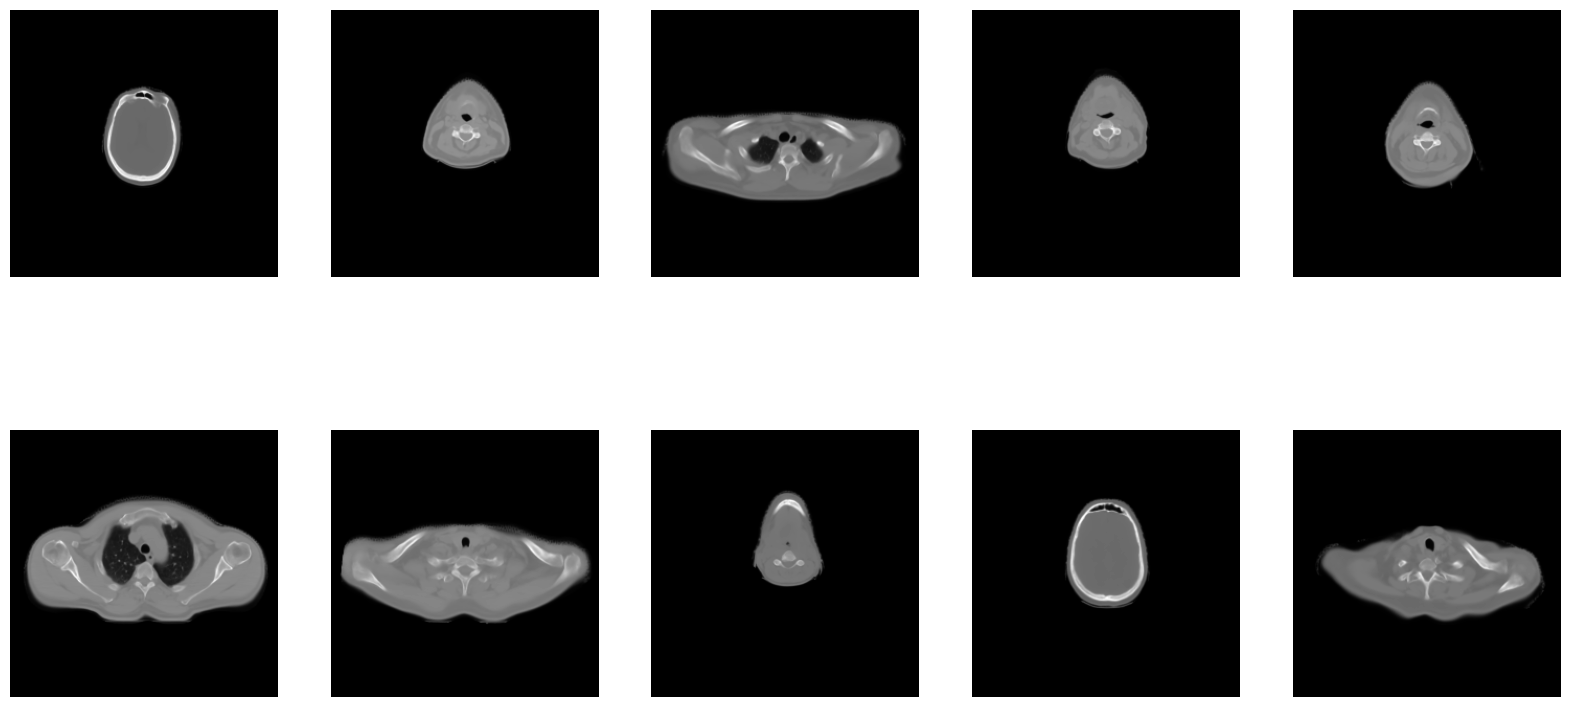

In [15]:
# I want to plot a tensor of shape torch.Size([10, 1, 256, 256]) in a grid of 2x5

# elements = torch.rand((10, 1, 256, 256))


fig, axis = plt.subplots(2, 5, figsize=(20, 10))
for i in range(2):
    for j in range(5):
        axis[i, j].imshow(elements[i*5+j], cmap="gray")
        axis[i, j].axis("off")
plt.show()
